In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random
import statistics
import scipy.sparse as sparse
from collections import Counter
import matplotlib as mpl

In [2]:
## Query Neo4j database to retrieve graph
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [3]:
# NetworkX Non directed graph definition
G = nx.Graph()
nodes = list(results.graph()._nodes.values())

# Load nodes
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

# Load edges    
rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [4]:
## Get connected components and pick the greatest one
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))
G = S[0]

The total number of components is:  12219


In [5]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [6]:
## Project graph into bipartite graph
G_bipartite = nx.Graph()
## Adding nodes
for node in nodes:
    if list(node.labels)[0] != 'Entity': # Not equal no entity class
        if node.id in G.nodes:
            G_bipartite.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)
vuelta = 0
## Add edges between sets computing edges. 
## An edge weight will be equal to number of entities set between same pair of Intermediary-Officer
for officer in labels['Officer']:
    officer_dict = {}
    for officer_neighbors in G.edges(officer):
        ## Compute weight edges
        for entity_neighbors in G.edges(officer_neighbors[1]):
            if G.nodes[entity_neighbors[1]]['kind'] == 'Intermediary':
                if entity_neighbors[1] in officer_dict:
                    officer_dict[entity_neighbors[1]] =  officer_dict[entity_neighbors[1]] +1
                else:
                    officer_dict[entity_neighbors[1]] = 1
    for k,v in officer_dict.items():
        G_bipartite.add_edge(officer, k, weight=v, type='Interactions')

In [7]:
# Bipartite dimensions
G_bipartite.number_of_nodes()

164669

In [8]:
# Check graph connectivity
nx.is_connected(G_bipartite)

True

In [9]:
## Sort node id's set by degree
intermediary_dict_degree = dict(G_bipartite.degree(labels['Intermediary']))
officer_dict_degree = dict(G_bipartite.degree(labels['Officer']))
intermediary_dict_degree = {k: v for k, v in sorted(intermediary_dict_degree.items(), key=lambda item: item[1],reverse=True)}
officer_dict_degree = {k: v for k, v in sorted(officer_dict_degree.items(), key=lambda item: item[1],reverse=True)}

In [10]:
## Bipartite adjacency matrix
A=nx.bipartite.biadjacency_matrix(G_bipartite,list(intermediary_dict_degree.keys()),list(officer_dict_degree.keys()))

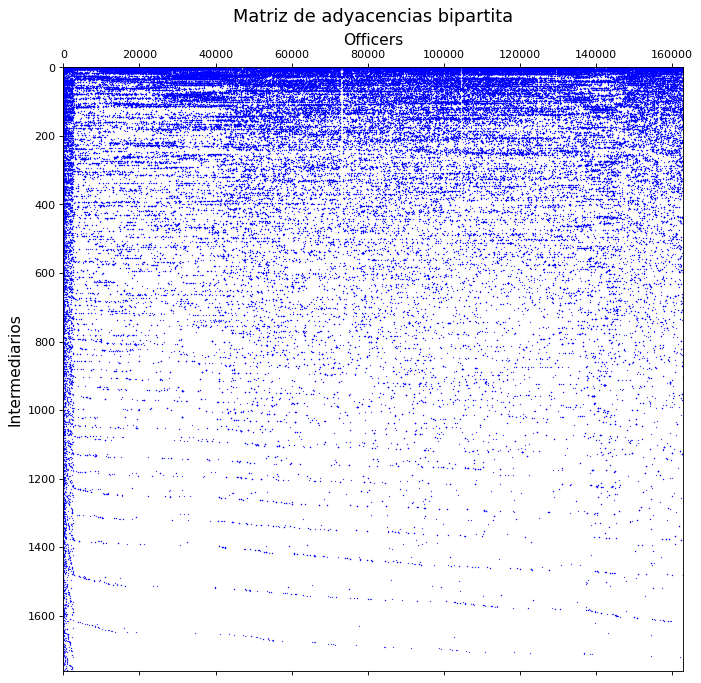

In [11]:
## Plot bipartite adjacency matrix
fig, axs = plt.subplots(figsize=(10, 10),dpi=80)
axs.spy(A,aspect="auto", markersize=0.2,alpha =1,color='blue')
axs.set_title("Matriz de adyacencias bipartita",pad=10,fontsize=16)
axs.set_ylabel("Intermediarios",fontsize=14)
axs.set_xlabel("Officers",fontsize=14)
axs.xaxis.set_label_position('top')
#plt.xlim(70000,80000)
#plt.ylim(0,50)
plt.show()

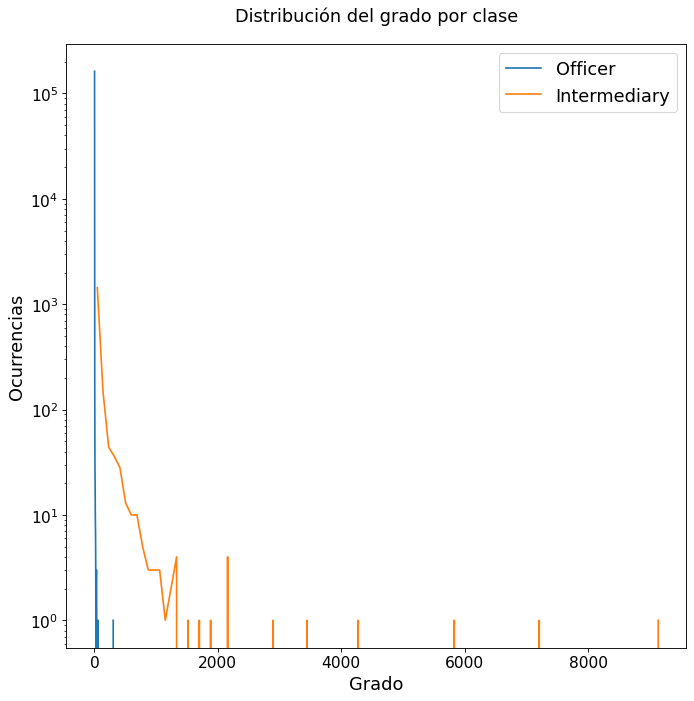

In [12]:
# Degree distribution by class
histogram_degrees_officer = list(dict(G_bipartite.degree(labels['Officer'])).values())
histogram_degrees_intermediaries = list(dict(G_bipartite.degree(labels['Intermediary'])).values())

plt.figure(figsize=(10, 10), dpi=80)

y,binEdges=np.histogram(histogram_degrees_officer,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Officer")

y,binEdges=np.histogram(histogram_degrees_intermediaries,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Intermediary")

plt.title('Distribución del grado por clase',fontsize=16,pad=20)
plt.xlabel('Grado',fontsize=16)
plt.ylabel('Ocurrencias',fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
p.show()

In [13]:
# Compute dict where keys are node id's and values are edges weight mean
weight_dict = {}
for u,v,data in G_bipartite.edges(data=True):
    weight_dict[u] = weight_dict.get(u, [])
    weight_dict[u].append(data['weight'])
    weight_dict[v] = weight_dict.get(v, [])
    weight_dict[v].append(data['weight'])
weight_dict_mean = {}
for key,value in weight_dict.items():
    weight_dict_mean[key] = statistics.mean(value)

In [14]:
## Graph bipartite associativity compute
scatter_associativity_officer_mean = []
scatter_associativity_intermediary_mean = []
scatter_associativity_officer_weight_mean = []
scatter_associativity_intermediary_weight_mean = []
scatter_associativity_officer_weight_degree = []
scatter_associativity_intermediary_weight_degree = []

for node_id,metadata in G_bipartite.nodes(data=True):
    node_degree = G_bipartite.degree(node_id)
    degree_mean = 0
    weight_mean = 0
    number_of_neighbors = len(list(G_bipartite.neighbors(node_id)))
    if G_bipartite.nodes[node_id]['kind'] == 'Intermediary':
        scatter_associativity_intermediary_weight_degree.append([node_degree,weight_dict_mean[node_id]])
    else:
        scatter_associativity_officer_weight_degree.append([node_degree,weight_dict_mean[node_id]])
    ## Iterate over neighbors
    for node_neighbor in G_bipartite.neighbors(node_id):
        neighbor_degree = G_bipartite.degree(node_neighbor)
        degree_mean = neighbor_degree + degree_mean
        weight_mean = weight_mean + weight_dict_mean[node_neighbor]
    if G_bipartite.nodes[node_id]['kind'] == 'Intermediary':
        scatter_associativity_intermediary_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
        scatter_associativity_intermediary_weight_mean.append(list([weight_dict_mean[node_id], weight_mean/number_of_neighbors]))
    else:
        scatter_associativity_officer_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
        scatter_associativity_officer_weight_mean.append(list([weight_dict_mean[node_id], weight_mean/number_of_neighbors]))        

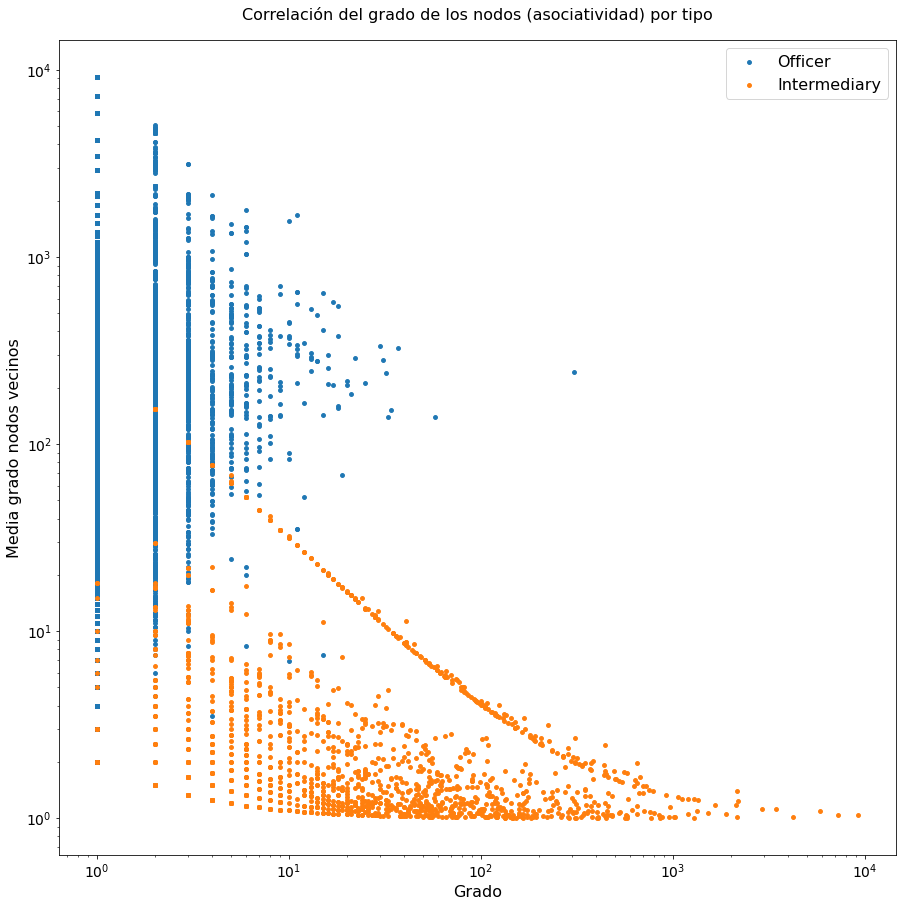

In [15]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Media grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

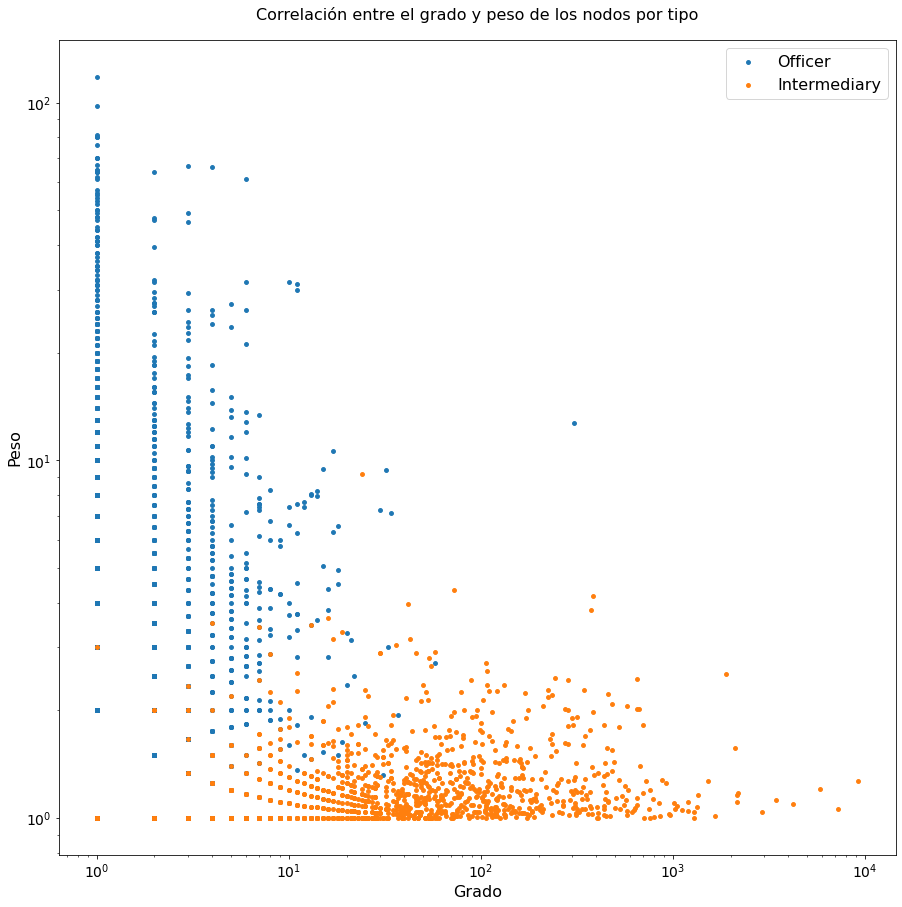

In [16]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_weight_degree)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_weight_degree)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Peso', fontsize=16)
plt.title('Correlación entre el grado y peso de los nodos por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

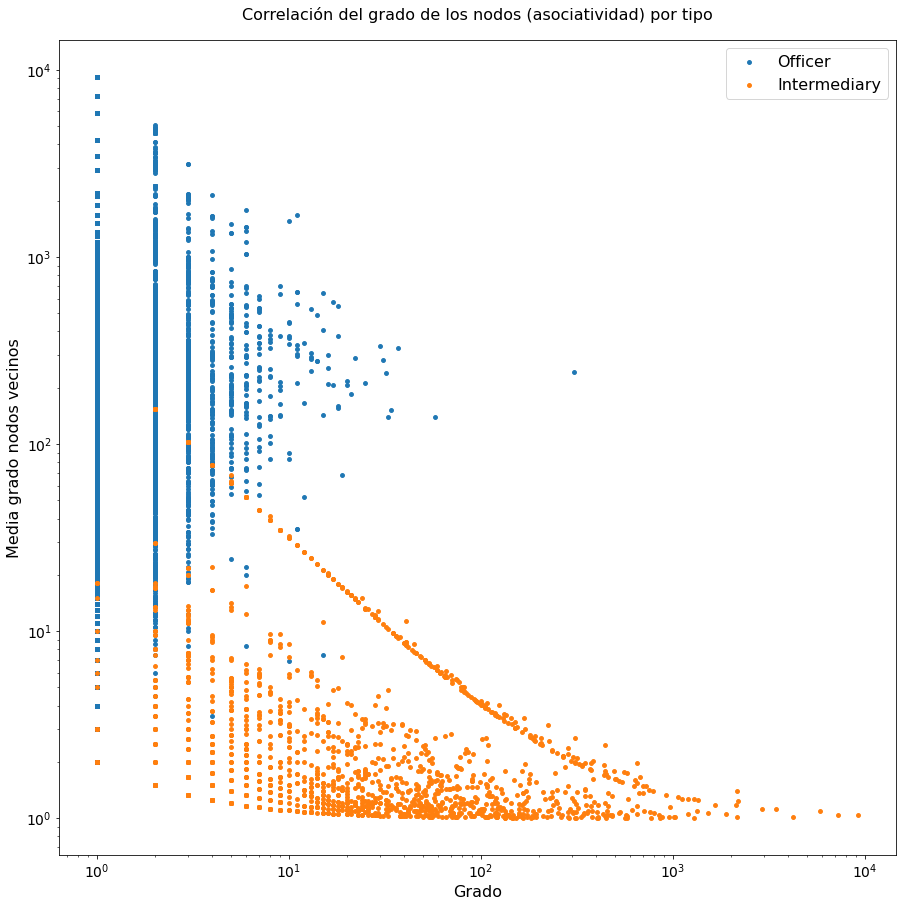

In [17]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Media grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
## Old method bipartite adjancecy matrix
"""
officer_dict = dict(G_bipartite.degree(labels['Officer']))
sorted_officer_dict = list(dict(sorted(officer_dict.items(), key=lambda item: item[1],reverse=True)).keys())

intermediary_dict = dict(G_bipartite.degree(labels['Intermediary']))
sorted_intermediary_dict = list(dict(sorted(intermediary_dict.items(), key=lambda item: item[1],reverse=True)).keys())
A=nx.bipartite.biadjacency_matrix(G_bipartite, sorted_officer_dict, sorted_intermediary_dict)
A_dense = A.todense().T
A_dense = A_dense.astype('float')
A_dense[A_dense==0.0] = np.nan
"""

In [ ]:
## Old method bipartite adjancecy matrix - Plot
"""
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
"""

In [ ]:
## Old method bipartite adjancecy matrix - Plot Focus
"""
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita foco nodos mayor grado",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
plt.xlim(50000,160000)
plt.ylim(1762,625)
plt.xlabel("Officers")
plt.ylabel("Intermediarios")
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
"""

In [22]:
## We construct a new graph bipartite removing those nodes with degree equal to 1
## New graph small relabelled
G_new = G_bipartite.copy()
remove_ids = []
for k,v in officer_dict_degree.items():
    if v == 1:
        remove_ids.append(k)
G_new.remove_nodes_from(remove_ids)

## new dict containing arrays on each key which represents node classes
labels = {}
for n, d in G_new.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)

In [23]:
intermediary_new_mapping = {}
officers_new_mapping = {}
counter=0
# We relabel node id's in order to have two distinct sets (bipartite).
# Rows represent intermediaries and Columns represent officers
# Id's, starting from zero, have appended a character ensuring they are unique
for old_id in sorted(list(labels['Intermediary'])):
    intermediary_new_mapping[old_id] = str(counter) + 'i'
    counter=counter+1
counter=0
for old_id in sorted(list(labels['Officer'])):
    officers_new_mapping[old_id] = str(counter) + 'o'
    counter=counter+1

In [26]:
# New bipartite graph which nodes has degree greater than 1 and are labeled according to bipartite sets
B = nx.Graph()
B.add_nodes_from(intermediary_new_mapping.values(), bipartite=0)
B.add_nodes_from(officers_new_mapping.values(), bipartite=1)
edges_bipartite = []

# Map node edges with new id's from bipartite sets
for u,v,data in G_new.edges(data=True):
    new_officer_id = None
    new_intermediary_id = None
    if u in intermediary_new_mapping:
        new_intermediary_id = intermediary_new_mapping[u] # New id's from intermediary
    else:
        new_officer_id = officers_new_mapping[u]  # New id's from officers
    if v in intermediary_new_mapping:
        new_intermediary_id = intermediary_new_mapping[v]  # New id's from intermediary
    else:
        new_officer_id = officers_new_mapping[v]  # New id's from officers
    edges_bipartite.append([new_intermediary_id,new_officer_id,data]) ## Edges array
B.add_edges_from(edges_bipartite) # Edges creation

In [27]:
# Check graph connectivity
nx.is_connected(B)

True

In [28]:
# Graph dimensions
B.number_of_nodes()

4338

In [30]:
# Sets (Officers and Intermediaries)
bottom_nodes, top_nodes = nx.bipartite.sets(B)
print('Intermediaries:',len(bottom_nodes),'Officers:',len(top_nodes))

Intermediaries: 1762 Officers: 2576


In [31]:
# We export edgelist as two distinct sets
# In order to achieve that, we parse edge list and append new line for each edge to csv file
with open('B-bipartite.csv','w') as file:
    for line in nx.bipartite.generate_edgelist(B,delimiter=',',data=["weight"]):
        file.write(''.join([c for c in line if c in '1234567890,']))
        file.write('\n')
        
intermediary_dict_degree = dict(B.degree(list(intermediary_new_mapping.values())))
officer_dict_degree = dict(B.degree(list(officers_new_mapping.values())))
intermediary_dict_degree = {k: v for k, v in sorted(intermediary_dict_degree.items(), key=lambda item: item[1],reverse=True)}
officer_dict_degree = {k: v for k, v in sorted(officer_dict_degree.items(), key=lambda item: item[1],reverse=True)}

In [32]:
# Get adyacency matrix and export it to csv
A=nx.bipartite.biadjacency_matrix(B,list(intermediary_dict_degree.keys()),list(officer_dict_degree.keys()))
pd.DataFrame(A.todense()).to_csv("matrix-bipartite.csv",header=None, index=None)